In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%load_ext tensorboard

## Import and preprocess the Data 

## Data import

In [ ]:
#load a mnist dataset
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

## Data preprocessing

### Data pipeline

In [ ]:
#1. get mnist from tensorflow datasets
mnist = tfds.load("mnist", split =["train","test"], as_supervised=True)
train_ds = mnist[0]
val_ds = mnist[1]

#2. Preproces the data using the map method or scan
def preprocess(data, batch_size, noise_rate=0.4):
  #data = data.map(lambda x, t: (tf.expand_dims(x, axis=-1)))
  data = data.map(lambda x, t: (tf.cast(x, float)))
  data = data.map(lambda x: (x/255.))
  noisy_data = data.map(lambda x: (tf.random.normal(x.shape.as_list(),mean=0, stddev=noise_rate) + x))
  noisy_data = noisy_data.map(lambda x: (tf.clip_by_value(x, clip_value_min=0, clip_value_max=1)))
  ds = tf.data.Dataset.zip((noisy_data, data))
  ds = ds.shuffle(1000)
  # doing batching with model.fit
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

train_ds = preprocess(train_ds, batch_size=32)
val_ds = preprocess(val_ds, batch_size=32)

### Apply data pipeline

## Plot of image + noise

In [ ]:
#function to plot the images
def plot(data):   
    n = len(data)
    plt.figure(figsize=(20, 5))
    for (noisy_img, img) in data:
        for i in range(n):
            ax = plt.subplot(2,n,i+1)
            plt.title("original") 
            plt.imshow(tf.squeeze(img[i].numpy()))
            
        for i in range(n):
            ax = plt.subplot(2,n,i+n+1)
            plt.title("original+noise")
            plt.imshow(tf.squeeze(noisy_img[i].numpy()))
            plt.gray()
    plt.show()


# The model classes

## The encoder

In [ ]:
class Encoder(tf.keras.Model):
  
  #1 Constructor
  def __init__(self):
    super(Encoder, self).__init__()
    #inherit functionality from parent class

    #list of layers of the network
    self.layers_list = [
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28,28,1)), # (batch, 14,14,1)
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'), # (batch, 7,7,1)
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(10, activation='relu')
    ]

  #2. call method (forward computation)
  def call(self, img, training=False):
    x = img
    for layer in self.layers_list:
      x = layer(x)

    return x

  #3 return latent dimensions for restoring in decoder
  def get_latent_dims(self):
    return [layer.output_shape for layer in self.layers_list]

## The decoder

In [ ]:
class Decoder(tf.keras.Model):
  
  #1 Constructor
  def __init__(self):
    super(Decoder, self).__init__()
    #inherit functionality from parent class

    #list of the layers of the network
    self.layers_list = [
        tf.keras.layers.Dense(1568, activation='relu'),
        tf.keras.layers.Reshape((7,7,32)),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')
    ]


  #2. call method (forward computation)
  def call(self, img, training=False):
    x = img
    for layer in self.layers_list:
      x = layer(x)

    return x

    

## The denoising autoencoder

In [ ]:
class Denoiser(tf.keras.Model):
  
    #1 Constructor
    def __init__(self):
        super(Denoiser, self).__init__()
        #inherit functionality from parent class

        #Regresion => MeanSquaredError, Adam Optimiser
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.loss = tf.keras.losses.MeanSquaredError()
        self.metrics_list = [
                            tf.keras.metrics.MeanSquaredError(name="loss"),
                            tf.keras.metrics.Accuracy(name="acc")
                           ]

        self.encoder = Encoder()
        self.decoder = Decoder()

    #2. call method (forward computation)
    def call(self, img, training=False):
        encoded = self.encoder(img)
        decoded = self.decoder(encoded)
        
        return decoded

    #3. metrics property
    @property
    def metrics(self):
        # return a list with all metrics in the model
        return self.metrics_list


    #4 reset all metrics object
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    #5 training step method
    def train_step(self, data):
        # update the state of the metrics according to loss
        # return a dictionary with metrics name as keys an metric results

        img, label = data
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss(label, output)

        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        #update the state of the metrics according to loss
        for metric in self.metrics:
            metric.update_state(label, output)

        # return a dictionary with metric names as keys and metric results as values
        return ((img[:10], output[:10]),{m.name : m.result() for m in self.metrics})
    

    #6. test step method
    def test_step(self, data):
        img, label = data
        output = self(img, training=False)
        loss = self.loss(label, output)
        #self.metrics[0].update_state(label, output)
        for metric in self.metrics:
            metric.update_state(label, output)

        return {"val_"+m.name : m.result() for m in self.metrics}


    

# Summary writer

In [ ]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_path = f"logs/train/"
val_log_path = f"logs/val/"
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path + current_time)
# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path + current_time)

# Training loop

In [ ]:
import tqdm
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path):
  #1. iterate over epochs
  for e in range(epochs):
    #2. train steps on all batchs in the training data
    for data in tqdm.tqdm(train_ds):
      ret,metrics = model.train_step(data)
    # 3. log and print data metrics
    with train_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])

    # print 10 inputs and their prediction for each epoch
    img_list, output_list = ret

    #print images every iteration
    n = len(img_list)
    plt.figure(figsize=(20, 5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      plt.title("image") 
      plt.imshow(tf.squeeze(img_list[i]))
    for i in range(n):
      ax = plt.subplot(2,n,i+n+1)
      plt.title("prediction")
      plt.imshow(tf.squeeze(output_list[i]))
      plt.gray()
    plt.show()

    #4 reset the metrics
    model.reset_metrics()

    #5. evaluate on validation data
    for data in val_ds:
      metrics = model.test_step(data)
    
    #6. log validation metrics
    with val_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
    
    #7. reset metric objects
    model.reset_metrics()

  #8 save model weights
  model.save_weights(save_path)

# Model training

## Model 1

100%|██████████| 1875/1875 [03:38<00:00,  8.59it/s]


MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['loss: 0.03987199813127518', 'acc: 0.0']


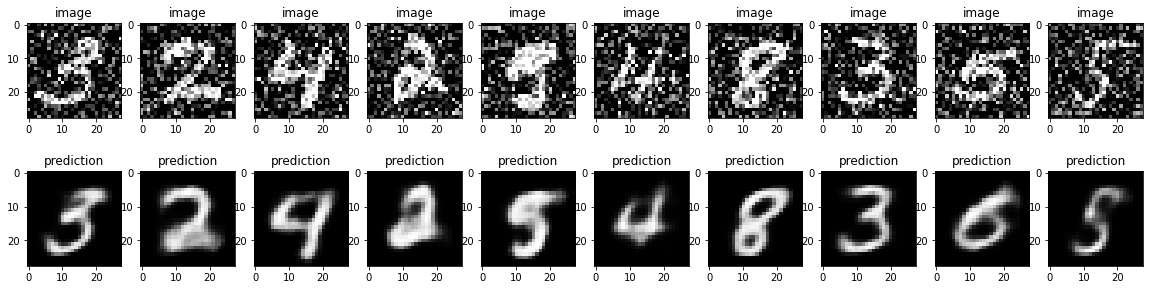

MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['val_loss: 0.026570133864879608', 'val_acc: 0.0']


100%|██████████| 1875/1875 [03:24<00:00,  9.17it/s]


MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['loss: 0.02534153312444687', 'acc: 0.0']


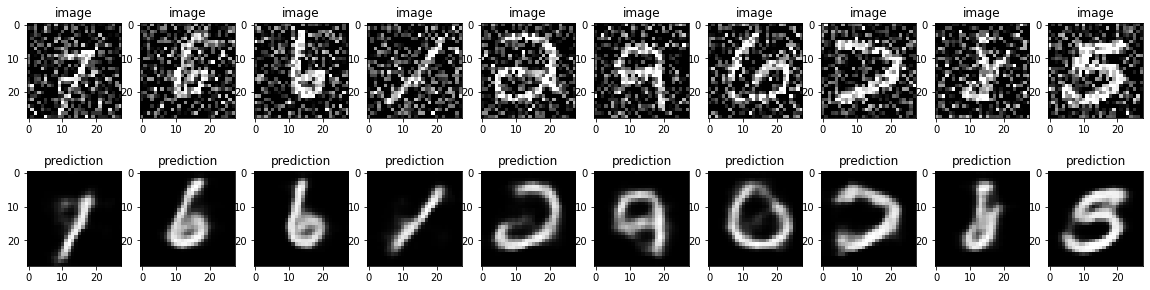

MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['val_loss: 0.023688936606049538', 'val_acc: 0.0']


100%|██████████| 1875/1875 [04:21<00:00,  7.16it/s]


MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['loss: 0.02317679673433304', 'acc: 0.0']


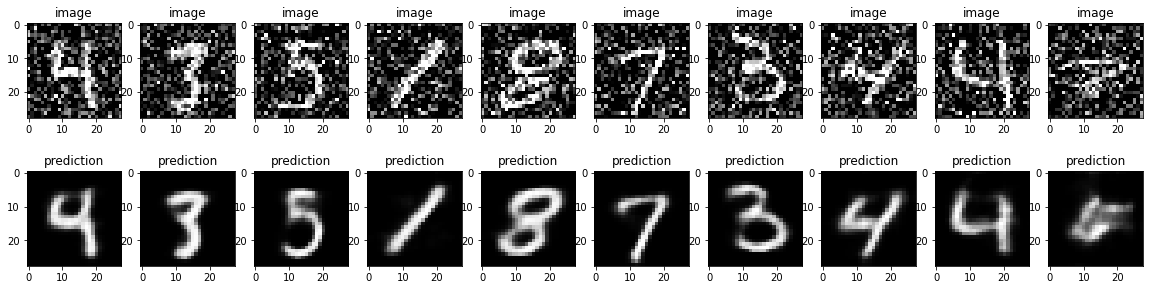

MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['val_loss: 0.021917767822742462', 'val_acc: 0.0']


100%|██████████| 1875/1875 [04:21<00:00,  7.16it/s]


MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['loss: 0.021930141374468803', 'acc: 4.251700502777567e-08']


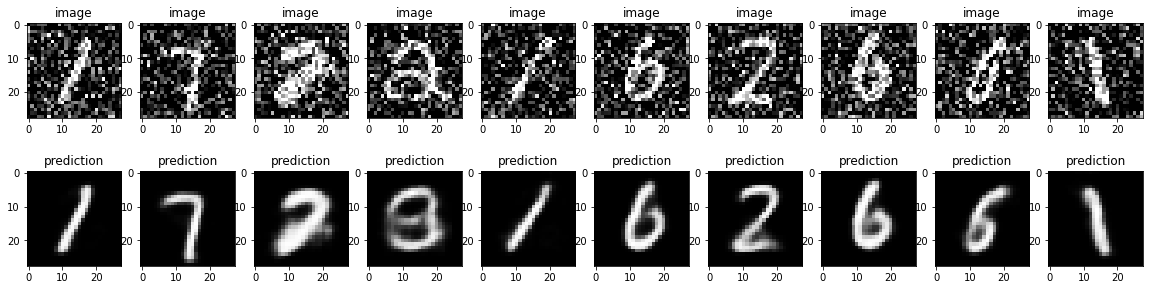

MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['val_loss: 0.020870700478553772', 'val_acc: 0.0']


100%|██████████| 1875/1875 [04:21<00:00,  7.16it/s]


MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['loss: 0.02112375572323799', 'acc: 0.0']


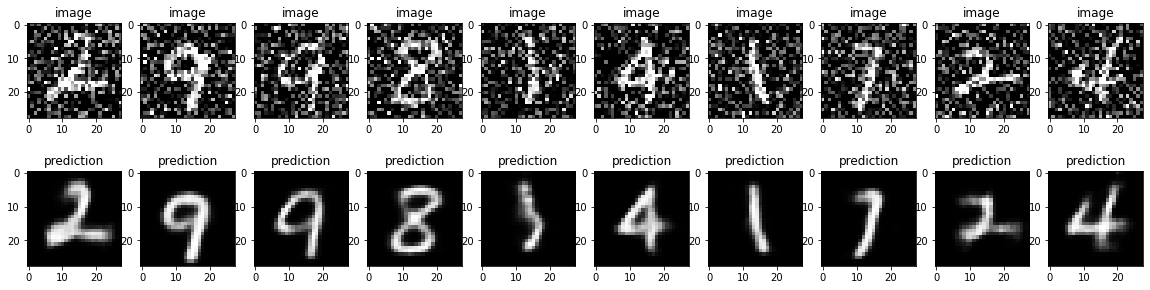

MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['val_loss: 0.020679740235209465', 'val_acc: 0.0']


100%|██████████| 1875/1875 [04:21<00:00,  7.16it/s]


MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['loss: 0.020574182271957397', 'acc: 2.1258502513887834e-08']


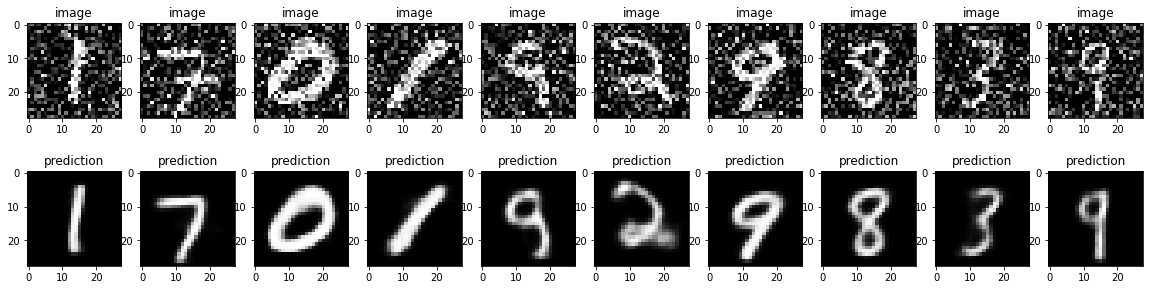

MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['val_loss: 0.01985113136470318', 'val_acc: 2.5510203727208136e-07']


100%|██████████| 1875/1875 [03:28<00:00,  8.98it/s]


MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['loss: 0.02016877755522728', 'acc: 0.0']


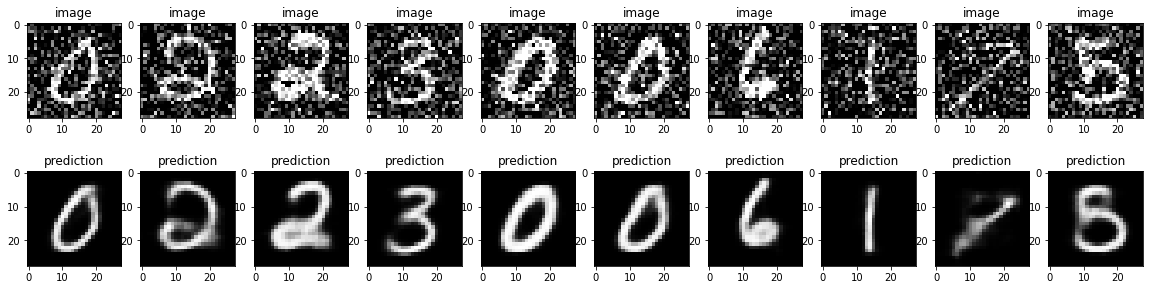

MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['val_loss: 0.019612859934568405', 'val_acc: 0.0']


100%|██████████| 1875/1875 [04:21<00:00,  7.16it/s]


MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['loss: 0.019898587837815285', 'acc: 0.0']


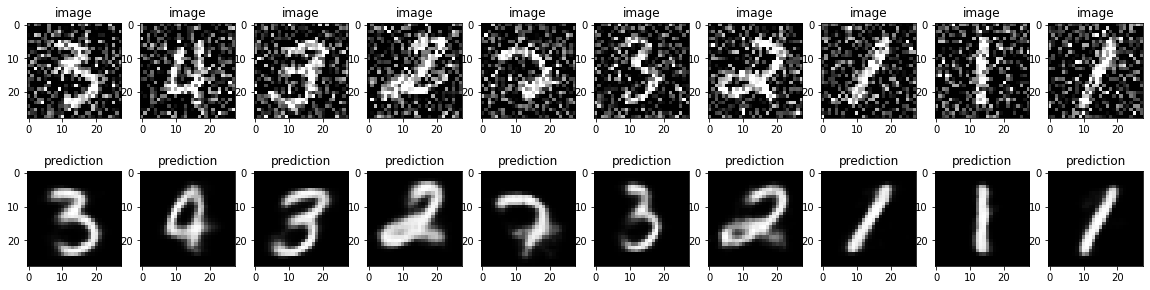

MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['val_loss: 0.019474361091852188', 'val_acc: 0.0']


 10%|█         | 191/1875 [00:22<03:05,  9.07it/s]

In [ ]:
#1. instantiate model
model = Denoiser() # this model has sigmoid as the activation function of the dense layer of the decoder
epochs=10

#2. choose a path to save the weights
save_path = "trained_model"

training_loop(model, train_ds,val_ds, epochs, train_summary_writer, val_summary_writer, save_path)

## Model 2

In [ ]:
#1. instantiate model
model2 = Denoiser() # this model has relu as the activation function for the first dense layer of the decoder
epochs=10

#2. choose a path to save the weights
save_path = "trained_model2"

training_loop(model2, train_ds,val_ds, epochs, train_summary_writer, val_summary_writer, save_path)

## Model 3

In [ ]:
#1. instantiate model
model3 = Denoiser() # this model has relu as the activation function for the first dense layer of the decoder
#model(tf.keras.Input((28,28,1)))
#model.summary()
epochs=10

#2. choose a path to save the weights
save_path = "trained_model3"

training_loop(model3, train_ds,val_ds, epochs, train_summary_writer, val_summary_writer, save_path)

In [ ]:
for img, noisy in train.take(1):
    img.shape

## Variational Autoencoder ##
Combines the encoder and decoder into an end-to-end model for training.

In [ ]:
class Sampling(tf.keras.Model):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE_Encoder(tf.keras.Model):

  def __init__(self):
    super(VAE_Encoder, self).__init__()
    #inherit functionality from parent class

    self.layers_list = [
      #tf.keras.layers.Input(shape=(32,28,28,1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28,28,1)), # (batch, 14,14,1)
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'), # (batch, 7,7,1)
      tf.keras.layers.Flatten()
    ]
    # mean
    self.dense1 = tf.keras.layers.Dense(10)
    # variance
    self.dense2 = tf.keras.layers.Dense(10)
    # sampling layer
    self.sampling = Sampling()

  #2. call method (forward computation)
  def call(self, img, training=False):
    x = img
    for layer in self.layers_list:
      x = layer(x)
    mean = self.dense1(x)
    var = self.dense2(x)
    embedding = self.sampling((mean, var))

    return mean, var, embedding

  #3 return latent dimensions for restoring in decoder
  def get_latent_dims(self):
    return [layer.output_shape for layer in self.layers_list]

class VAE_Decoder(tf.keras.Model):
  
  #1 Constructor
  def __init__(self):
    super(VAE_Decoder, self).__init__()
    #inherit functionality from parent class

    self.layers_list = [
        tf.keras.layers.Dense(1568, activation='relu'),
        tf.keras.layers.Reshape((7,7,32)),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')
    ]


  #2. call method (forward computation)
  def call(self, img, training=False):
    x = img
    for layer in self.layers_list:
      x = layer(x)

    return x

    

In [ ]:
class VAE_Denoiser(tf.keras.Model):
  
    #1 Constructor
    def __init__(self):
        super(VAE_Denoiser, self).__init__()
        #inherit functionality from parent class

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.loss = tf.keras.losses.MeanSquaredError()
        self.metrics_list = [
                            tf.keras.metrics.MeanSquaredError(name="loss"),
                            tf.keras.metrics.Accuracy(name="acc")
                           ]

        self.encoder = VAE_Encoder()
        self.decoder = VAE_Decoder()

    #2. call method (forward computation)
    def call(self, img, training=False):
        mean, var, embedding  = self.encoder(img)
        decoded = self.decoder(embedding)
        
        return decoded

    #3. metrics property
    @property
    def metrics(self):
        # return a list with all metrics in the model
        return self.metrics_list


    #4 reset all metrics object
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    #5 training step method
    def train_step(self, data):
        # update the state of the metrics according to loss
        # return a dictionary with metrics name as keys an metric results
        #self.plot(data)
        img, label = data
        #print(img.shape.as_list())
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss(label, output)
        
  
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        #update the state of the metrics according to loss
        #self.metrics[0].update_state(label, output)
        for metric in self.metrics:
            metric.update_state(label, output)

        # return a dictionary with metric names as keys and metric results as values
        return ((img[:10], output[:10]),{m.name : m.result() for m in self.metrics})
    

    #6. test step method
    def test_step(self, data):
        img, label = data
        output = self(img, training=False)
        loss = self.loss(label, output)
        #self.metrics[0].update_state(label, output)
        for metric in self.metrics:
            metric.update_state(label, output)

        return {"val_"+m.name : m.result() for m in self.metrics}


    

In [ ]:
#1. instantiate model
vae_model = VAE_Denoiser() # this model has relu as the activation function for the first dense layer of the decoder
epochs=10

#2. choose a path to save the weights
save_path = "trained_model_vae"

training_loop(vae_model, train_ds,val_ds, epochs, train_summary_writer, val_summary_writer, save_path)

# Testing

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same", input_shape=(28,28,1)))
model.output_shape

In [ ]:
model.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same"))
model.output_shape

In [ ]:
model.add(tf.keras.layers.Flatten())
model.output_shape

In [ ]:
model.add(tf.keras.layers.Dense(10, activation='sigmoid'))
model.output_shape

In [ ]:
model.add(tf.keras.layers.Dense(1568, activation='sigmoid'))
model.output_shape

In [ ]:
model.add(tf.keras.layers.Reshape((7,7,32)))
model.output_shape

In [ ]:
model.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'))
model.output_shape

In [ ]:
model.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'))
model.output_shape

In [ ]:
model.add(tf.keras.layers.Conv2D(1, kernel_size=3, activation='sigmoid', padding='same'))
model.output_shape